In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 데이터 불러오기

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

3    105
1    105
0    103
2     83
Name: label, dtype: int64

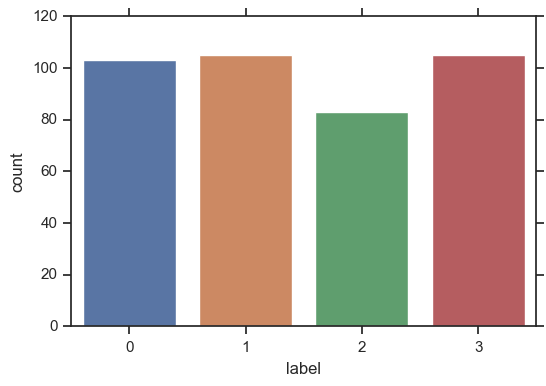

In [3]:
Y_train = train["label"]

# 'label' column 을 drop
X_train = train.drop(labels = ["label"],axis = 1) 

g = sns.countplot(Y_train)

Y_train.value_counts()

# 데이터 normalization 

In [4]:
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [5]:
Y_train = to_categorical(Y_train, num_classes = 4)

In [6]:
Y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

# Train, Validation 데이터 분리 

In [7]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.1, 
                                                  random_state=random_seed)

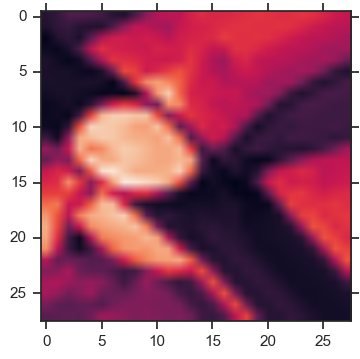

In [8]:
g = plt.imshow(X_train[0][:,:,0])

# 모델 정의

In [25]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2))) # stride 2,2 이면 그림이 반으로 줄어든다.
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)         

# 모델 최적화 

In [27]:
model.compile(optimizer = Adam(lr=0.001) , loss = "categorical_crossentropy", metrics=["accuracy"])

In [28]:
# ReduceLROnPlateau
# 모델의 정확도가 향상되지 않는 경우 learning rate(LR)을 줄여주는 callback 클래스

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, #3번까지 참다가 val_acc이 개선되지 않으면 LR을 줄인다.
                                            verbose=1, 
                                            factor=0.5, # LR * 0.5 만큼 줄인다.
                                            min_lr=0.00001)  # 최소 LR

In [29]:
epochs = 30 # epoch은 학습횟수
batch_size = 11 # steps_per_epoch 맞추려고. 작을수록 학습 잘 해. 그러나 학습시간 길어

# Image Augmentation (데이터 증강) 

In [30]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # 랜덤하게 사진 회전 각도 (0~180)
        zoom_range = 0.1, # 랜덤하게 사진 확대 범위
        width_shift_range=0.1,  # 랜덤하게 수평으로 평행 이동 범위(전체 넓이에 대한 비율)
        height_shift_range=0.1,  # 랜덤하게 수직으로 평행 이동 범위(전체 높이에 대한 비율)
        horizontal_flip=False,  # 랜덤하게 수평으로 뒤집음
        vertical_flip=False)  # 랜덤하게 수직으로 뒤집음


datagen.fit(X_train)

# 학습 

In [31]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2,
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
 - 3s - loss: 1.3483 - accuracy: 0.3536 - val_loss: 1.0590 - val_accuracy: 0.5750
Epoch 2/30


C:\Users\danny\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: lr,accuracy,loss,val_accuracy,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 3s - loss: 0.9911 - accuracy: 0.5333 - val_loss: 0.9078 - val_accuracy: 0.6750
Epoch 3/30
 - 3s - loss: 0.8902 - accuracy: 0.6000 - val_loss: 0.7332 - val_accuracy: 0.7500
Epoch 4/30
 - 2s - loss: 0.7020 - accuracy: 0.7217 - val_loss: 0.4881 - val_accuracy: 0.8000
Epoch 5/30
 - 3s - loss: 0.6542 - accuracy: 0.6928 - val_loss: 0.5000 - val_accuracy: 0.8250
Epoch 6/30
 - 3s - loss: 0.6547 - accuracy: 0.7130 - val_loss: 0.4504 - val_accuracy: 0.8000
Epoch 7/30
 - 2s - loss: 0.5499 - accuracy: 0.7826 - val_loss: 0.4708 - val_accuracy: 0.8250
Epoch 8/30
 - 2s - loss: 0.5341 - accuracy: 0.7478 - val_loss: 0.3626 - val_accuracy: 0.8750
Epoch 9/30
 - 3s - loss: 0.4978 - accuracy: 0.7884 - val_loss: 0.2708 - val_accuracy: 0.9500
Epoch 10/30
 - 3s - loss: 0.4839 - accuracy: 0.7884 - val_loss: 0.2412 - val_accuracy: 0.9500
Epoch 11/30
 - 2s - loss: 0.3774 - accuracy: 0.8580 - val_loss: 0.2255 - val_accuracy: 0.9250
Epoch 12/30
 - 3s - loss: 0.4820 - accuracy: 0.8058 - val_loss: 0.2993 - val_ac

# ==========평가==========

# loss, accuracy 

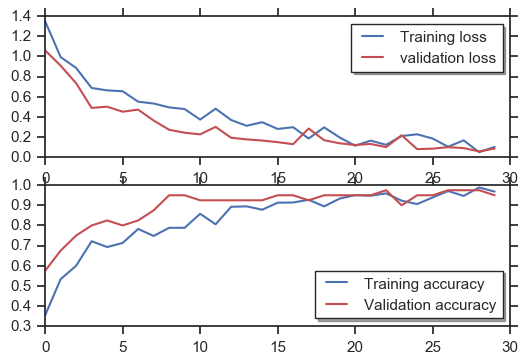

In [32]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# confusion matrix 

In [33]:
# validation set 예측
Y_pred = model.predict(X_val)
# 예측 값 중 가장 큰 값의 인덱스를 label로
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# 실제 값 중 가장 큰 값의 인덱스를 label로
Y_true = np.argmax(Y_val,axis = 1) 
# 예측값과 실제값을 활용해 confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print(confusion_mtx)

[[13  1  0  0]
 [ 0  7  1  0]
 [ 0  0  7  0]
 [ 0  0  0 11]]


In [34]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, 
                            target_names=['label 0', 'label 1','label 2','label 3']))

             precision    recall  f1-score   support

    label 0       1.00      0.93      0.96        14
    label 1       0.88      0.88      0.88         8
    label 2       0.88      1.00      0.93         7
    label 3       1.00      1.00      1.00        11

avg / total       0.95      0.95      0.95        40



# ==========결과========== 

# Test set 예측 

In [36]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

results

0    0
1    0
2    0
3    3
4    2
5    2
6    3
7    3
8    3
9    3
Name: Label, dtype: int64